## NeuroMatch Academy
### Introduction to Models
Different flavors of models are used to understand neural data.
#### "What" Models
To investigate "what" models we will:
- Load a dataset with spiking activity from hundreds of neurons and understand how it is organized
- Make plots to visualize characteristics of the spiking activity across the population
- Compute the distribution of “inter-spike intervals” (ISIs) for a single neuron
- Consider several formal models of this distribution’s shape and fit them to the data “by hand”

#### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# @title Plotting functions

def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()

#@title Data retrieval
#@markdown This cell downloads the example dataset that we will use in this tutorial.
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

#### Section 1
_Exploring the Steinmetz dataset_

A subset of data from Neuropixels probes implanted in brains of mice. Electrode measurements captured local variations in electric field due to spiking neurons. Spike sorting algorithm used to infer spike times. Cluster spikes origin: a single cluster of sorted spikes is causally attributed to a single neuron.

#### Interpreting the Data:

In [3]:
print(type(spike_times))
print(spike_times.shape)

<class 'numpy.ndarray'>
(734,)


<font color=red>spike_times</font> is a numpy array of 734 entries in only one dimension.

In [9]:
# type and shape of randomly selected entries:
idx = [0,321,555]
for val in idx:
    print(
      type(spike_times[val]),
      spike_times[val].shape,
      sep="\n",
    )

<class 'numpy.ndarray'>
(826,)
<class 'numpy.ndarray'>
(9723,)
<class 'numpy.ndarray'>
(3218,)


All 1D arrays but with different shapes. Now we will check the NumPy types of values in these arrays and first few elements.

In [10]:
i_neurons = [0, 321]
i_print = slice(0, 5)

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    spike_times[i].dtype, # using dtype instead of python var type
    spike_times[i][i_print],
    "\n",
    sep="\n"
  )

Neuron 0:
float32
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


Neuron 321:
float32
[1.0698667 1.1536334 1.2403667 1.7072    1.799    ]




Both arrays contain floats with 32 bits of precision. 

From this we can infer the following from the data set:
- <font color=red>spike_times</font> is 1D, its length is the number of neurons (734): by indexing we select a subset of neurons)
- Array's in <font color=red>spike_times</font> are also 1D and correspond to a single neuron, entries are floats, length is number of spikes attributed to that neuron

Calculating and storing number of neurons and spikes per neuron for later use:

In [11]:
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


#### Spike Counts
Counting and plotting totl spike counts. Data shows us spikes are variable between neurons, some tend to spike more in a given period.

- Plot a histogram with defined constant bin width to compare "loud" or "quiet" neurons to the average.
- Calculate percentage of neurons below the average spike count

68.0% of neurons are below the mean


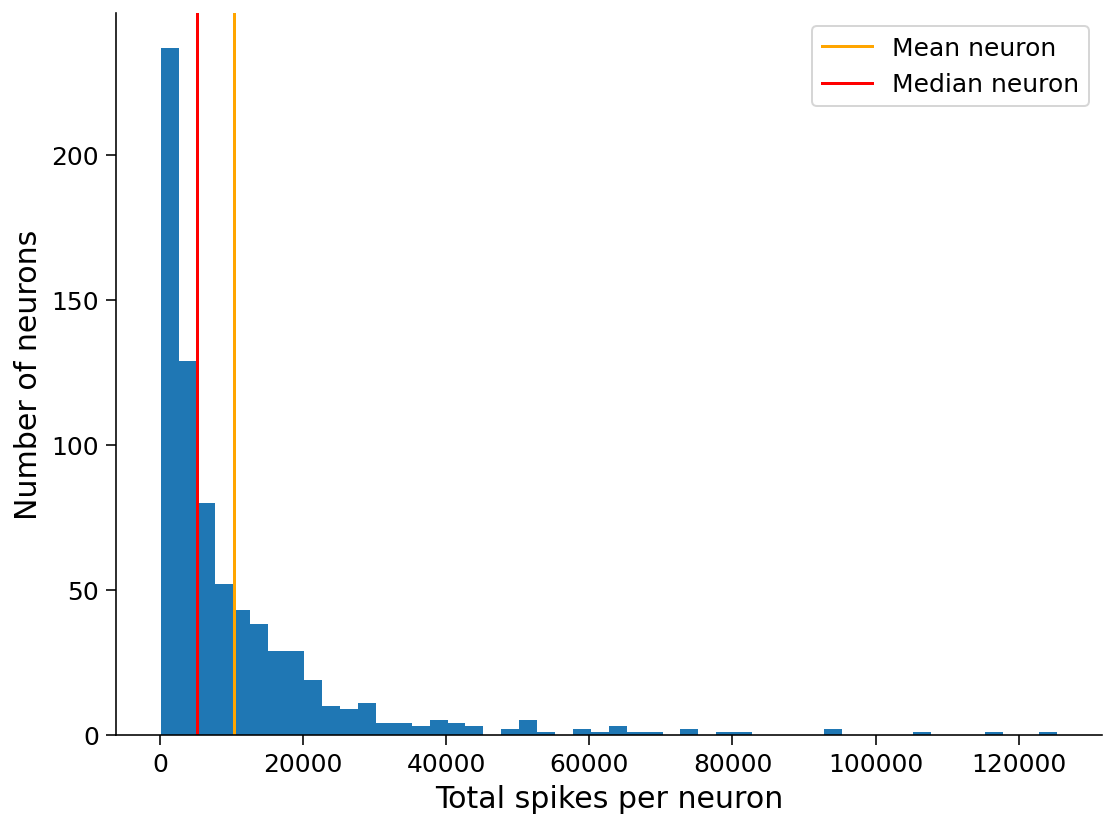

In [15]:
mean_spike_count = np.mean(total_spikes_per_neuron)
median_spike_count = np.median(total_spikes_per_neuron)

plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron") # show average neuron
plt.axvline(median_spike_count, color="red", label="Median neuron") # show median neuron
plt.legend();

frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()
print(f"{frac_below_mean:2.1%} of neurons are below the mean")

In [19]:
# calculate interquartile range
q3, q1 = np.percentile(total_spikes_per_neuron, [75 ,25])
iqr = q3 - q1
iqr

11490.0

Shows majority of neurons are relatively "quiet" compared to the mean, small number of neurons are very "loud": must have spiked more frequently to reach a large count.

#### Getting a subset of the data 
_Visualise trains of spikes_

Recordings are long, define short time interval and restrict visualization to this interval. 
Using the pre made function <font color =green>restrict_spike_times</font> will streamline this process.

In [22]:
def restrict_spike_times(spike_times, interval):
  """Given a spike_time dataset, restrict to spikes within given interval.

  Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

  Returns:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)
help(restrict_spike_times)

Help on function restrict_spike_times in module __main__:

restrict_spike_times(spike_times, interval)
    Given a spike_time dataset, restrict to spikes within given interval.
    
    Args:
      spike_times (sequence of np.ndarray): List or array of arrays,
        each inner array has spike times for a single neuron.
      interval (tuple): Min, max time values; keep min <= t < max.
    
    Returns:
      np.ndarray: like `spike_times`, but only within `interval`



In [23]:
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

Find fraction of total spikes that fall in this interval

In [24]:
original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")

0.33% of the total spikes are in the interval


Find ratio between interval duration and experiment duration. Approximate the experiment duration by taking the minimum and maximum spike time in the whole dataset. “concatenate” all of the neurons into one array and then use np.ptp (“peak-to-peak”) to get the diff.

In [25]:
spike_times_flat = np.concatenate(spike_times)
experiment_duration = np.ptp(spike_times_flat)
interval_duration = t_interval[1] - t_interval[0]

frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval")

0.37% of the total time is in the interval


Ratio's are similar, suggesting average spike rate of neuronal population in the interval is not very different compared to entire recording.

#### Plotting spike trains and rasters
Can plot spikes now we have a representative subset.

Looking at a single neuron

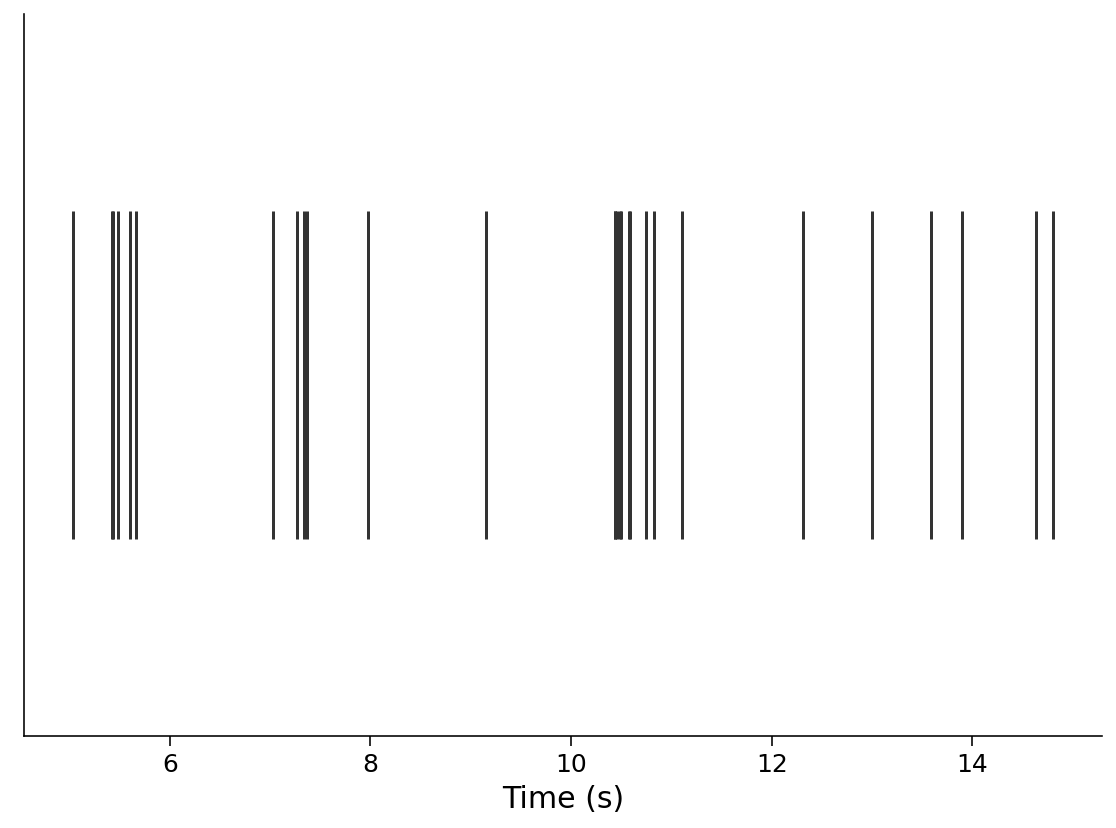

In [26]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

A "raster plot is where spikes from each neuron appear in a different row, for example with 3 neurons:

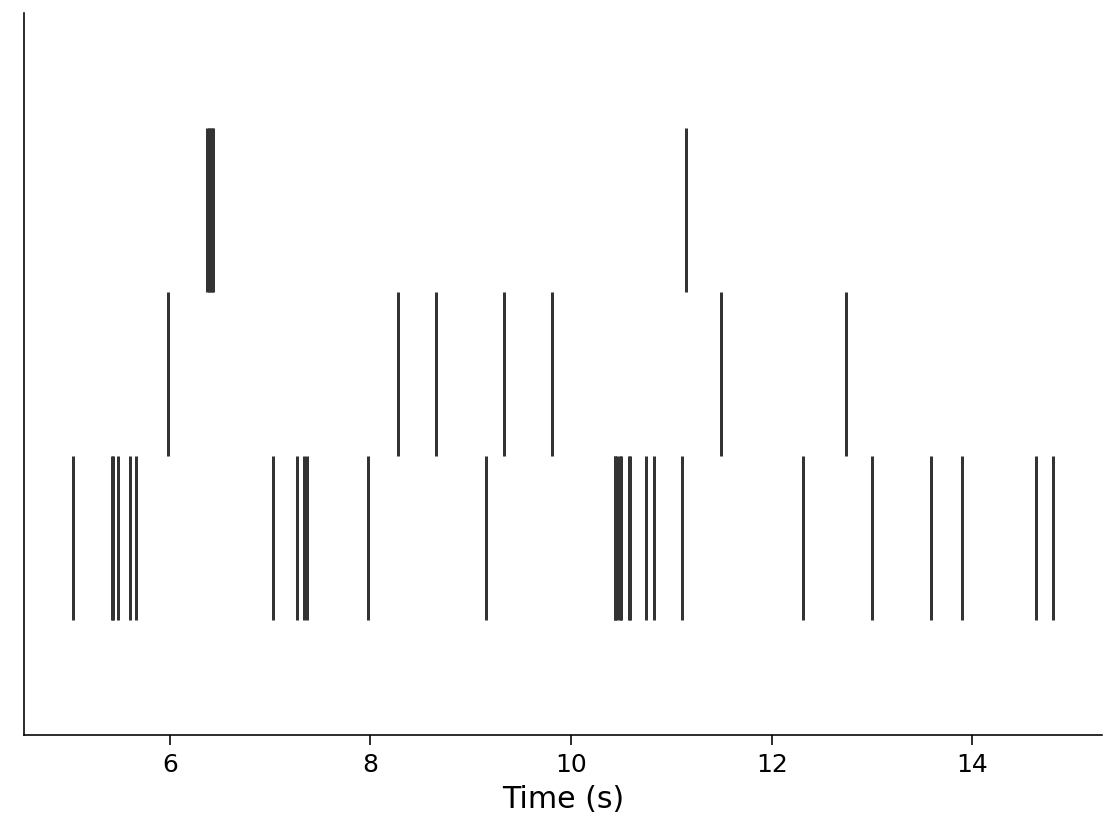

In [27]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

Plotting a large number of neurons gives a sense of charachteristics of the population, for example showing every 5th neuron recorded:

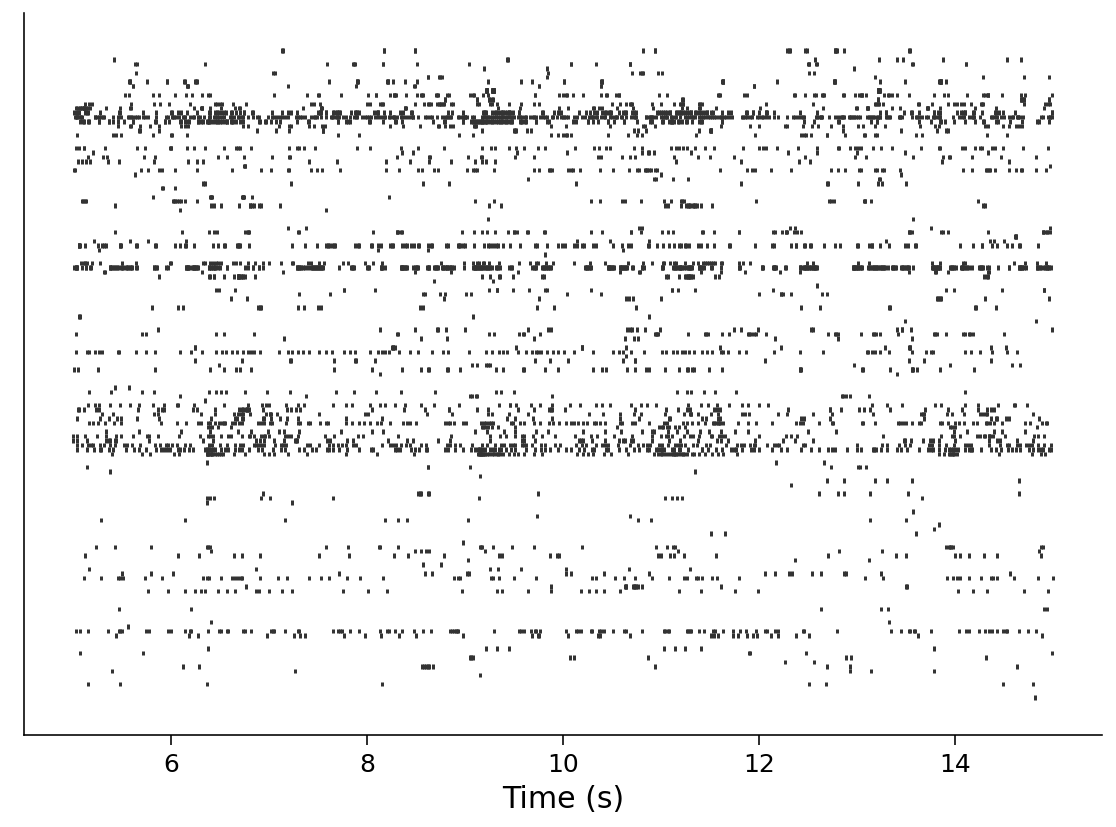

In [28]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

Can see clusters of neurons that spike more fequently than others. If there is a distribution of inter-spike intervals then it must reflect physiology.

#### Visualizing activity
"Scientific questions are informed by existing models. So, what knowledge do we already have that can inform questions about this data?"

Physical constraints on neuron spiking, spiking costs energy, energy that can only be obtained at a finite rate.

Neurons should have a refractory period: can only fire as quickly as their metabolic processes can support.

Can ask:
- How long does a neuron wait to spike again?
- Can we transform spike times into something else, to address questions like these more directly?

We can consider inter-spike-intervals (ISI's). Time difference between consecutive spikes of same neuron.

#### Plot distribution of ISI's for single neuron
Histogram to show distribution of ISI's for one neuron in the dataset.

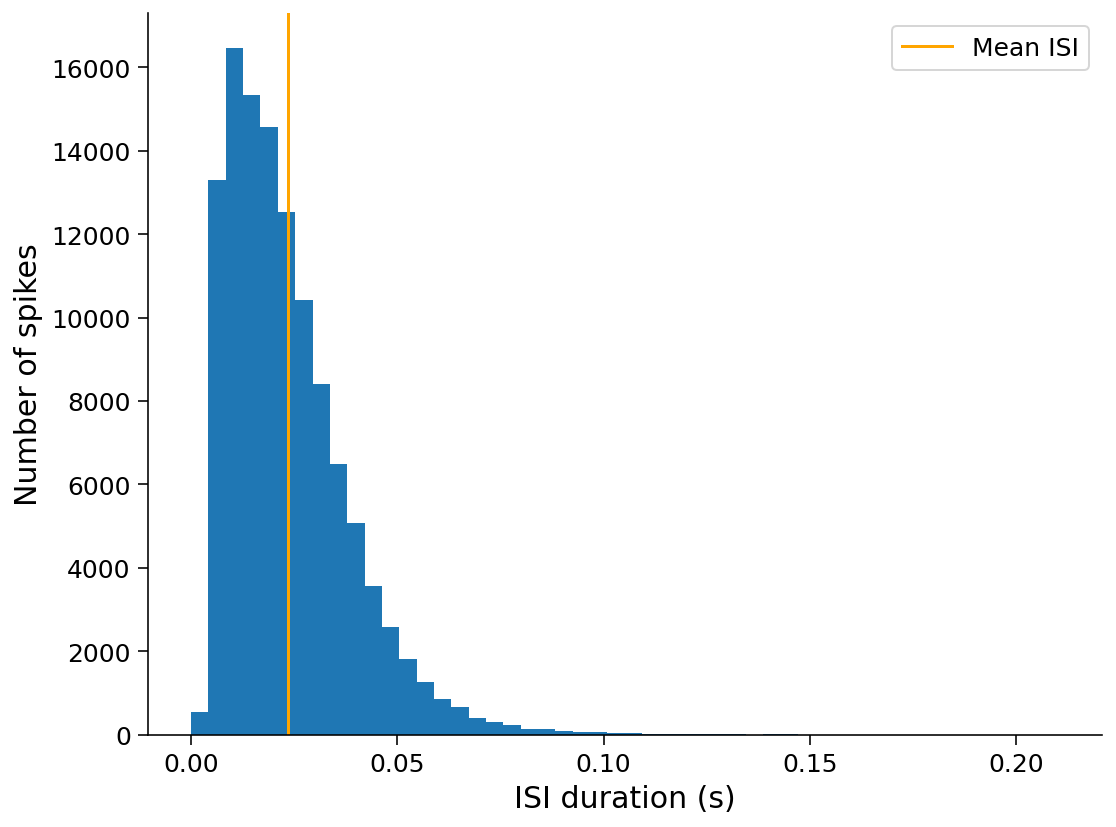

In [30]:
def compute_single_neuron_isis(spike_times, neuron_idx):
    single_neuron_spikes = spike_times[neuron_idx]
    isis = np.diff(single_neuron_spikes)
    return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualize ISIs
plot_isis(single_neuron_isis)

__Interpreting__: generally shorter ISI's are predominant, counts decrease rapidly and somewhat smoothly with increasing ISI.  Counts also rapidly decrease to zero with decreasing ISI below the maximum of the distribution (8-11 ms). The absence of these very low ISIs agrees with the refractory period hypothesis: the neuron cannot fire quickly enough to populate this region of the ISI distribution.

#### Functional form of an ISI distribution
The ISI histograms seem to follow continuous, monotonically decreasing functions above their maxima. The function is clearly non-linear. Could it belong to a single family of functions?

It is motivating to use the idea of explaining physiological phenomena with a mathematical function. this allows it to be modelled and therefore predicted.

We may expect the function to follow the form of exponential, inverse or linear. Defining these as functions:

In [31]:
def exponential(xs, scale, rate, x0):
  """A simple parameterized exponential function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    rate (float): Exponential growth (positive) or decay (negative) rate.
    x0 (float): Horizontal offset.

  """
  ys = scale * np.exp(rate * (xs - x0))
  return ys

def inverse(xs, scale, x0):
  """A simple parameterized inverse function (`1/x`), applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    x0 (float): Horizontal offset.

  """
  ys = scale / (xs - x0)
  return ys

def linear(xs, slope, y0):
  """A simple linear function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    slope (float): Slope of the line.
    y0 (float): y-intercept of the line.

  """
  ys = slope * xs + y0
  return ys

#### Summary
- Loaded neural data and understood how it was organized
- Used basic plots to visualize data
- Started to think about using mathematical formalisms to understand or explain some physiological phenomenon. 
- All of this only allowed us to understand “What” the data looks like.